In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
np.random.seed(3)

In [3]:
df = pd.read_csv("~\Documents\yelp_academic_dataset_review.csv")

In [4]:
df.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful
0,Xqd0DzHaiyRqVH3WRG7hzg,15SdjuK7DmYqUAj6rjGowg,dr. goldberg offers everything i look for in a...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,5,2007-05-17,review,2
1,H1kH6QZV7Le4zqTRNxoZow,RF6UnRTtG7tWMcrO2GEoAg,"Unfortunately, the frustration of being Dr. Go...",0,vcNAWiLM4dR7D2nwwJ7nCA,0,2,2010-03-22,review,2
2,zvJCcrpm2yOZrxKffwGQLA,-TsVN230RCkLYKBeLsuz7A,Dr. Goldberg has been my doctor for years and ...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-02-14,review,1
3,KBLW4wJA_fwoWmMhiHRVOA,dNocEAyUucjT371NNND41Q,Been going to Dr. Goldberg for over 10 years. ...,0,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-03-02,review,0
4,zvJCcrpm2yOZrxKffwGQLA,ebcN2aqmNUuYNoyvQErgnA,Got a letter in the mail last week that said D...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-05-15,review,2


In [5]:
df.describe()

,votes.cool,votes.funny,stars,votes.useful
count,1.125458e+06,1.125458e+06,1.125458e+06,1.125458e+06
mean,6.533705e-01,5.250805e-01,3.737435e+00,1.132278e+00
std,1.712005e+00,1.633618e+00,1.299347e+00,2.125121e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00
max,1.370000e+02,1.410000e+02,5.000000e+00,1.660000e+02


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125458 entries, 0 to 1125457
Data columns (total 10 columns):
user_id         1125458 non-null object
review_id       1125458 non-null object
text            1125457 non-null object
votes.cool      1125458 non-null int64
business_id     1125458 non-null object
votes.funny     1125458 non-null int64
stars           1125458 non-null int64
date            1125458 non-null object
type            1125458 non-null object
votes.useful    1125458 non-null int64
dtypes: int64(4), object(6)
memory usage: 85.9+ MB


In [7]:
df = df[['text', 'stars']]
#df = df[0:100000] #to reduce training time for algo dev purpose. Remove and check if new dataset is balanced
df = df.dropna()

In [8]:
df = df.groupby('stars').apply(lambda i: i.sample(25000))
df = df.loc[df.stars != 3]
#df.loc[df.stars < 3, ['stars']] = 0
#df.loc[df.stars > 3, ['stars']] = 1
labels = df['stars'].map(lambda x : 1 if int(x) > 3 else 0)
labels.value_counts().plot(kind = 'bar')

In [9]:
X, x_test, Y, y_test = train_test_split(df.text, labels, test_size = 0.15, shuffle = True)

In [10]:
max_words = 2000
max_len = 150
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X)

sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen = max_len)

In [19]:
y_test = tf.convert_to_tensor(y_test, dtype = tf.float32)
Y = tf.convert_to_tensor(Y, dtype = tf.float32)

In [20]:
sequences_matrix.shape

(85000, 150)

In [27]:
model = keras.Sequential()
model.add(keras.layers.Embedding(max_words, 32))
model.add(keras.layers.Conv1D(32, kernel_size = 3, strides = 1, padding = 'same'))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dropout(rate = 0.2))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          64000     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          3104      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)               

In [28]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [29]:
history = model.fit(sequences_matrix, Y, epochs = 5, validation_split = 0.1)

Train on 76500 samples, validate on 8500 samples
Epoch 1/5
76500/76500 [==============================] - 70s 921us/sample - loss: 0.2685 - accuracy: 0.8880 - val_loss: 0.2109 - val_accuracy: 0.9147
Epoch 2/5
76500/76500 [==============================] - 69s 906us/sample - loss: 0.1887 - accuracy: 0.9269 - val_loss: 0.1858 - val_accuracy: 0.9247
Epoch 3/5
76500/76500 [==============================] - 69s 904us/sample - loss: 0.1578 - accuracy: 0.9405 - val_loss: 0.1814 - val_accuracy: 0.9282
Epoch 4/5
76500/76500 [==============================] - 69s 903us/sample - loss: 0.1371 - accuracy: 0.9497 - val_loss: 0.2028 - val_accuracy: 0.9285
Epoch 5/5
76500/76500 [==============================] - 70s 919us/sample - loss: 0.1170 - accuracy: 0.9567 - val_loss: 0.2020 - val_accuracy: 0.9262


In [30]:
model.evaluate(test_sequences_matrix, y_test)

15000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.1900067524174849, 0.93013334]

In [31]:
predictions = model.predict_classes(test_sequences_matrix)

In [32]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7733
           1       0.92      0.94      0.93      7267

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000



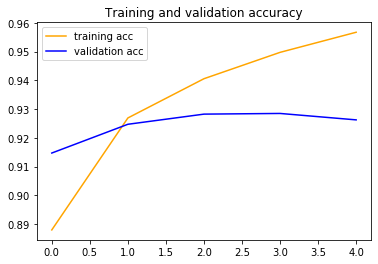

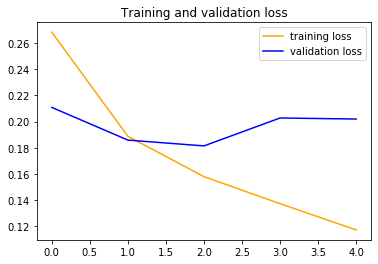

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training loss')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()